imports

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

Load raw dataframes

In [5]:
shape_df = gpd.read_file('C:/Users/20220678/Microsoft VS Code/JBG050-DC2-GRP21/data/Output_Areas_2021_EW_BGC_V2_-6371128854279904124/OA_2021_EW_BGC_V2.shp')
crime_df = pd.read_csv('C:/Users/20220678/Microsoft VS Code/JBG050-DC2-GRP21/data/curated_data/crime.csv')
income_df = pd.read_excel('C:/Users/20220678/Microsoft VS Code/JBG050-DC2-GRP21/data/demographic_data/saiefy1920finalqaddownload280923.xlsx', sheet_name='Total annual income')
lsoa_df = gpd.read_file('C:/Users/20220678/Microsoft VS Code/JBG050-DC2-GRP21/data/London-wards-2018/London-wards-2018_ESRI/London_Ward_CityMerged.shp')
surveys = pd.read_excel('C:/Users/20220678/Microsoft VS Code/JBG050-DC2-GRP21/data/PAS_T&Cdashboard_to Q3 23-24.xlsx', sheet_name='Borough')
outcomes_df = pd.read_csv('C:/Users/20220678/Microsoft VS Code/JBG050-DC2-GRP21/data/curated_data/outcome.csv')
stop_n_search_df = pd.read_csv('C:/Users/20220678/Microsoft VS Code/JBG050-DC2-GRP21/data/curated_data/stop_and_search.csv')

--- 

# Data Preprocessing

### Getting coordinates and bounding boxes for boroughs in the crimes_df

In [6]:
# helper function to get the district name from the LSOA name
def get_district_name(lsoa_name):
    # print(lsoa_name)
    if pd.isna(lsoa_name):
        return 'Not identified'
    return ' '.join(lsoa_name.split()[:-1])

crime_df['District'] = crime_df['LSOA name'].apply(get_district_name)

# standardize the names of the districts
crime_df['District'] = crime_df['District'].str.title()
lsoa_df['DISTRICT'] = lsoa_df['DISTRICT'].str.title()

# Rename 'City And County Of The City Of London' to 'City Of London'
# And 'City Of Westminster' to 'Westminster' in lsoa_df (geopandas)
lsoa_df['DISTRICT'] = lsoa_df['DISTRICT'].replace('City And County Of The City Of London', 'City Of London')
lsoa_df['DISTRICT'] = lsoa_df['DISTRICT'].replace('City Of Westminster', 'Westminster')

# shrink crimes df to only include the boroughs in the geopandas df
crime_df = crime_df[crime_df['District'].isin(lsoa_df['DISTRICT'])]

# Create a boroughs_df by dissolving the lsoa_df by the DISTRICT column
boroughs_df = lsoa_df.dissolve(by='DISTRICT')

# keep only required columns from boroughs_df
boroughs_df['District'] = boroughs_df.index
boroughs_df = boroughs_df[['District', 'geometry']]

# merge the two dataframes on 'District'
crimes_boroughs_df = pd.merge(crime_df, boroughs_df, on='District')

### Merge crimes and outcomes data

In [7]:
outcomes_df = pd.read_csv('C:/Users/20220678/Microsoft VS Code/JBG050-DC2-GRP21/data/curated_data/outcome.csv')
outcomes_df = outcomes_df[['Crime ID', 'Outcome type']]

# merge the two dataframes on 'Crime ID'
crimes_outcomes_df = pd.merge(crimes_boroughs_df, outcomes_df, on='Crime ID')

### Also merge income dataframe

In [8]:
income_df = pd.read_excel('C:/Users/20220678/Microsoft VS Code/JBG050-DC2-GRP21/data/demographic_data/saiefy1920finalqaddownload280923.xlsx', sheet_name='Total annual income')
income_df.columns = income_df.iloc[3].values
income_df = income_df[4:]

# keep only needed columns
income_df = income_df[['Local authority name', 'Total annual income (£)',
       'Upper confidence limit (£)', 'Lower confidence limit (£)',
       'Confidence interval (£)']]

income_df['Local authority name'] = income_df['Local authority name'].str.title()
# rename 'Local authority name' to 'District' in income_df
income_df = income_df.rename(columns={'Local authority name': 'District'})
# group by 'District' and take the mean of the income columns
income_df = income_df.groupby('District').mean().reset_index()

# merge the two dataframes on 'District'
crimes_income_df = pd.merge(crimes_outcomes_df, income_df, on='District')

---

### Merge ethnicity data

In [9]:
ethnicity_df = pd.read_excel("C:/Users/20220678/Microsoft VS Code/JBG050-DC2-GRP21/data/demographic_data/datadownload.xlsx")

In [10]:
ethnicity_df.columns = ethnicity_df.iloc[3].values
ethnicity_df = ethnicity_df.iloc[4:]

In [11]:
ethnicity_df['Area name'] = ethnicity_df['Area name'].str.title()
ethnicity_df = ethnicity_df.rename(columns={'Area name':'District'})

crimes_ethnicity_df = crimes_income_df.merge(ethnicity_df, on='District')

---

### Lastly add religious data to the dataset

In [12]:
religion_df = pd.read_excel("C:/Users/20220678/Microsoft VS Code/JBG050-DC2-GRP21/data/religion.xlsx")

In [13]:
religion_df.columns = religion_df.iloc[3].values
religion_df = religion_df.iloc[4:]

In [14]:
religion_df['Area name'] = religion_df['Area name'].str.title()
religion_df = religion_df.rename(columns={'Area name':'District'})
# religion_df['District'] = religion_df['District'].str.title

crime_religion_df = crimes_ethnicity_df.merge(religion_df, on='District')

In [15]:
crime_religion_df.shape

(2531977, 77)

# Visualizations

### Chloropleth map of crime counts

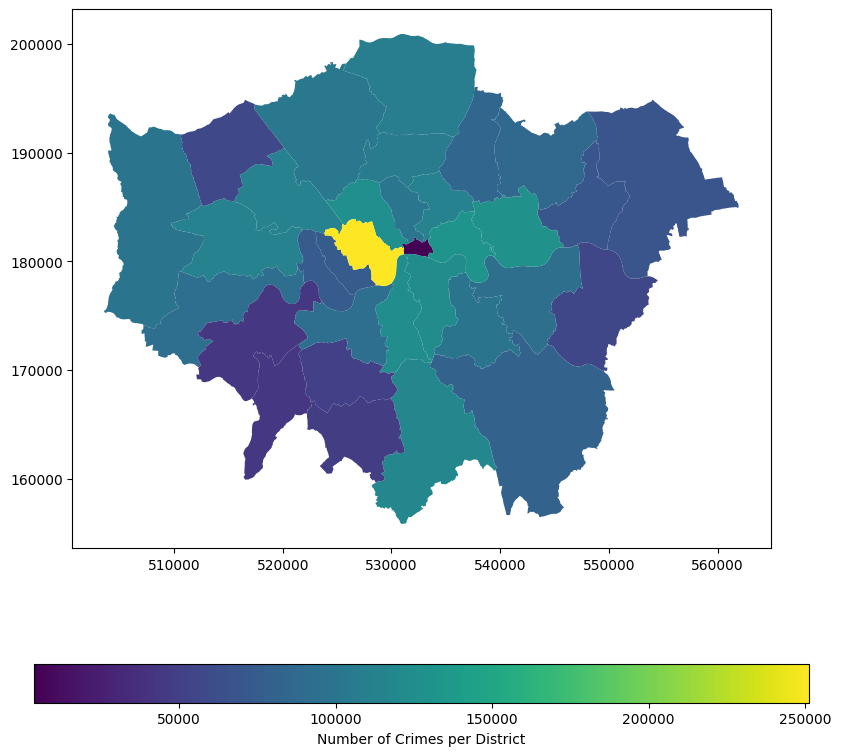

In [16]:
crime_counts = crimes_boroughs_df.groupby('District').size().reset_index(name='Crime Count')
lsoa_df = lsoa_df.dissolve(by='DISTRICT')
lsoa_df['District'] = lsoa_df.index
lsoa_df.reset_index(drop=True, inplace=True)
choropleth_data = lsoa_df.merge(crime_counts, on='District')

# Create the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
choropleth_data.plot(column='Crime Count', ax=ax, legend=True,
                     legend_kwds={'label': "Number of Crimes per District",
                                  'orientation': "horizontal"})
plt.show()

---

### Read the survey file

In [17]:
surveys = pd.read_excel('C:/Users/20220678/Microsoft VS Code/JBG050-DC2-GRP21/data/PAS_T&Cdashboard_to Q3 23-24.xlsx', sheet_name='Borough')

In [18]:
survey_boroughs = surveys['Borough'].unique().tolist()

In [19]:
[b.title() for b in survey_boroughs if b not in [i.title() for i in boroughs_df]]

['Barking And Dagenham',
 'Barnet',
 'Bexley',
 'Brent',
 'Bromley',
 'Camden',
 'Croydon',
 'Ealing',
 'Enfield',
 'Greenwich',
 'Hackney',
 'Hammersmith And Fulham',
 'Haringey',
 'Harrow',
 'Havering',
 'Hillingdon',
 'Hounslow',
 'Islington',
 'Kensington And Chelsea',
 'Kingston Upon Thames',
 'Lambeth',
 'Lewisham',
 'Merton',
 'Newham',
 'Redbridge',
 'Richmond Upon Thames',
 'Southwark',
 'Sutton',
 'Tower Hamlets',
 'Waltham Forest',
 'Wandsworth',
 'City Of Westminster',
 'Richmond Upon Thames']

In [20]:
crime_religion_df.shape

(2531977, 77)

In [21]:
crime_religion_df.columns

Index(['Crime ID', 'Month', 'Reported by', 'Falls within', 'Longitude',
       'Latitude', 'Location', 'LSOA code', 'LSOA name', 'Crime type',
       'Last outcome category', 'Context', 'District', 'geometry',
       'Outcome type', 'Total annual income (£)', 'Upper confidence limit (£)',
       'Lower confidence limit (£)', 'Confidence interval (£)', 'Area code_x',
       'Asian, Asian British or Asian Welsh: Bangladeshi\n(number)',
       'Asian, Asian British or Asian Welsh: Chinese\n(number)',
       'Asian, Asian British or Asian Welsh: Indian\n(number)',
       'Asian, Asian British or Asian Welsh: Pakistani\n(number)',
       'Asian, Asian British or Asian Welsh: Other Asian\n(number)',
       'Black, Black British, Black Welsh, Caribbean or African: African\n(number)',
       'Black, Black British, Black Welsh, Caribbean or African: Caribbean\n(number)',
       'Black, Black British, Black Welsh, Caribbean or African: Other Black\n(number)',
       'Mixed or Multiple ethnic gro

In [22]:
crime_counts = crime_religion_df.groupby('District').size().reset_index(name='CrimeCount')
crime_religion_df = crime_religion_df.merge(crime_counts, on='District', how='left')

In [23]:
# These are the criteria of the clustering
features_df = crime_religion_df[['CrimeCount']]

# Fill missing values with the mean of each column
features_df = features_df.fillna(features_df.mean())

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)

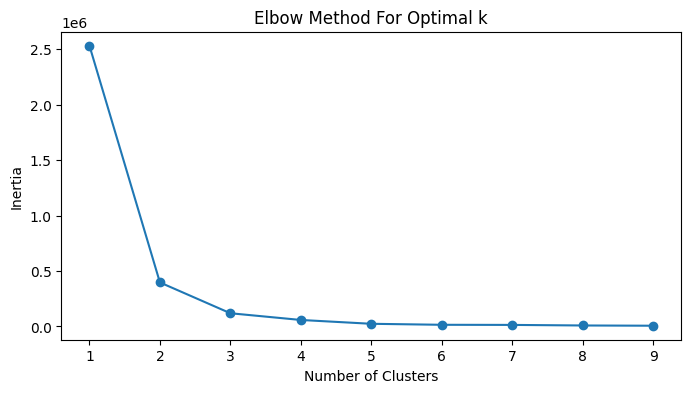

In [24]:
# Elbow Method
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)
crime_religion_df['Cluster'] = cluster_labels

In [25]:
# List of boroughs by cluster
for cluster in sorted(crime_religion_df['Cluster'].unique()):
    print(f"Cluster {cluster}:")
    boroughs_in_cluster = crime_religion_df[crime_religion_df['Cluster'] == cluster]['District'].unique()
    print(boroughs_in_cluster)
    print("\n")

Cluster 0:
['Brent' 'Camden' 'Croydon' 'Lambeth' 'Ealing' 'Enfield' 'Hackney'
 'Southwark' 'Newham' 'Tower Hamlets']


Cluster 1:
['Westminster']


Cluster 2:
['Barnet' 'Greenwich' 'Bromley' 'Lewisham' 'Islington' 'Hillingdon'
 'Haringey' 'Hounslow' 'Kensington And Chelsea' 'Redbridge'
 'Waltham Forest' 'Wandsworth']


Cluster 3:
['Barking And Dagenham' 'Bexley' 'City Of London' 'Hammersmith And Fulham'
 'Harrow' 'Havering' 'Kingston Upon Thames' 'Merton'
 'Richmond Upon Thames' 'Sutton']




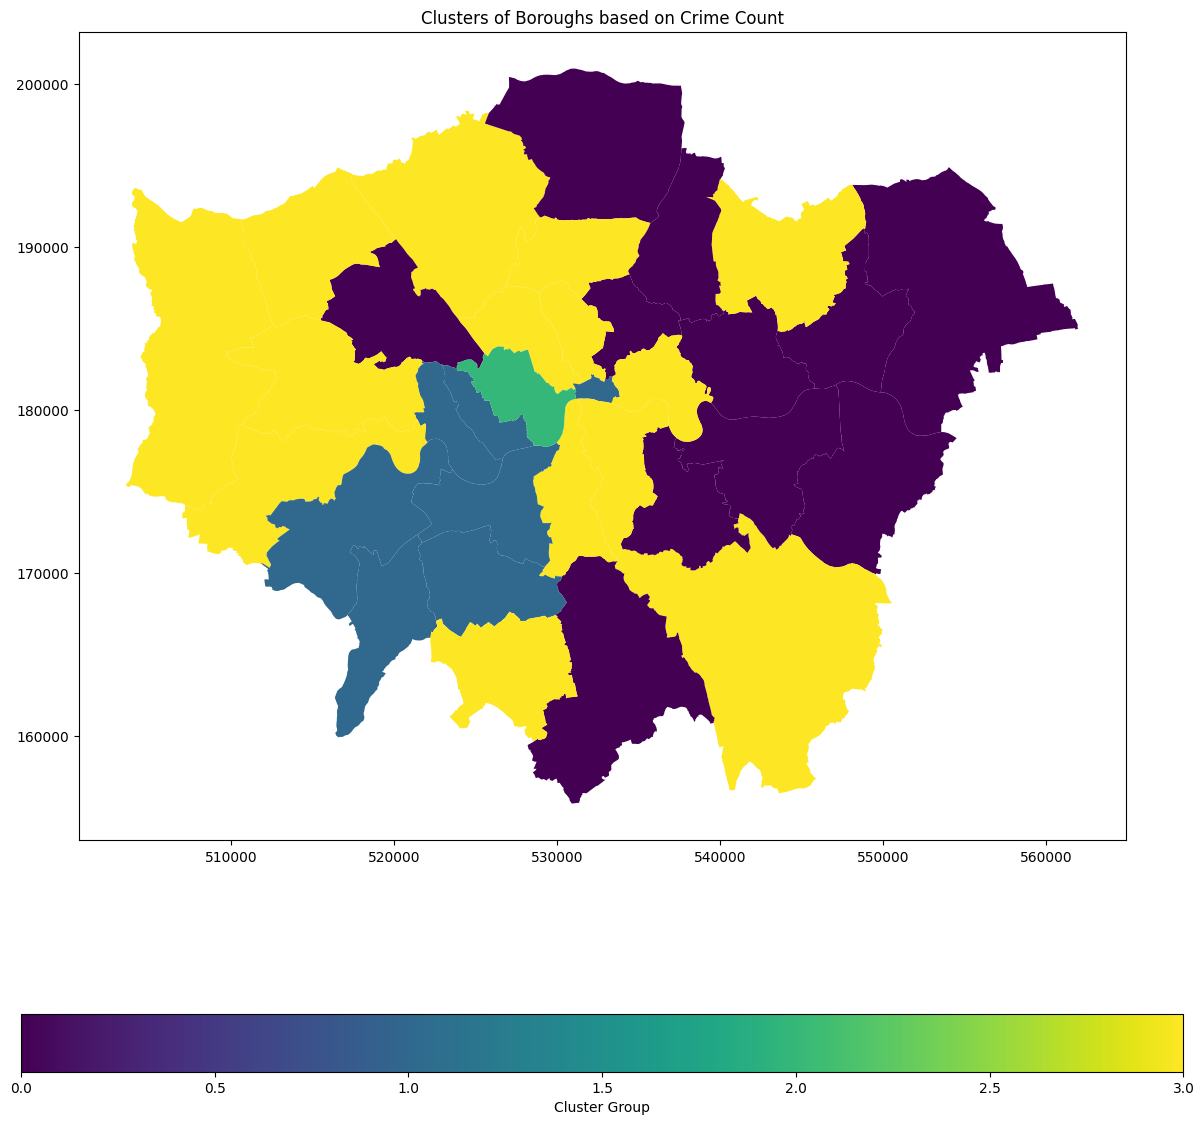

In [29]:
boroughs_df = boroughs_df[['District', 'geometry']]
boroughs_with_clusters = boroughs_df.merge(crime_religion_df[['District', 'Cluster']].drop_duplicates(), on='District', how='left')
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
boroughs_with_clusters.plot(column='Cluster', ax=ax, legend=True, cmap='viridis',
                            legend_kwds={'label': "Cluster Group", 'orientation': "horizontal"})
plt.title('Clusters of Boroughs based on Crime Count')
plt.show()


Cluster 0:
['Barking And Dagenham' 'Bexley' 'Greenwich' 'Brent' 'Lewisham' 'Croydon'
 'Enfield' 'Hackney' 'Havering' 'Newham' 'Waltham Forest']


Cluster 1:
['City Of London' 'Hammersmith And Fulham' 'Kensington And Chelsea'
 'Kingston Upon Thames' 'Merton' 'Richmond Upon Thames' 'Wandsworth']


Cluster 2:
['Westminster']


Cluster 3:
['Barnet' 'Camden' 'Bromley' 'Islington' 'Lambeth' 'Ealing' 'Hillingdon'
 'Haringey' 'Harrow' 'Hounslow' 'Southwark' 'Redbridge' 'Sutton'
 'Tower Hamlets']




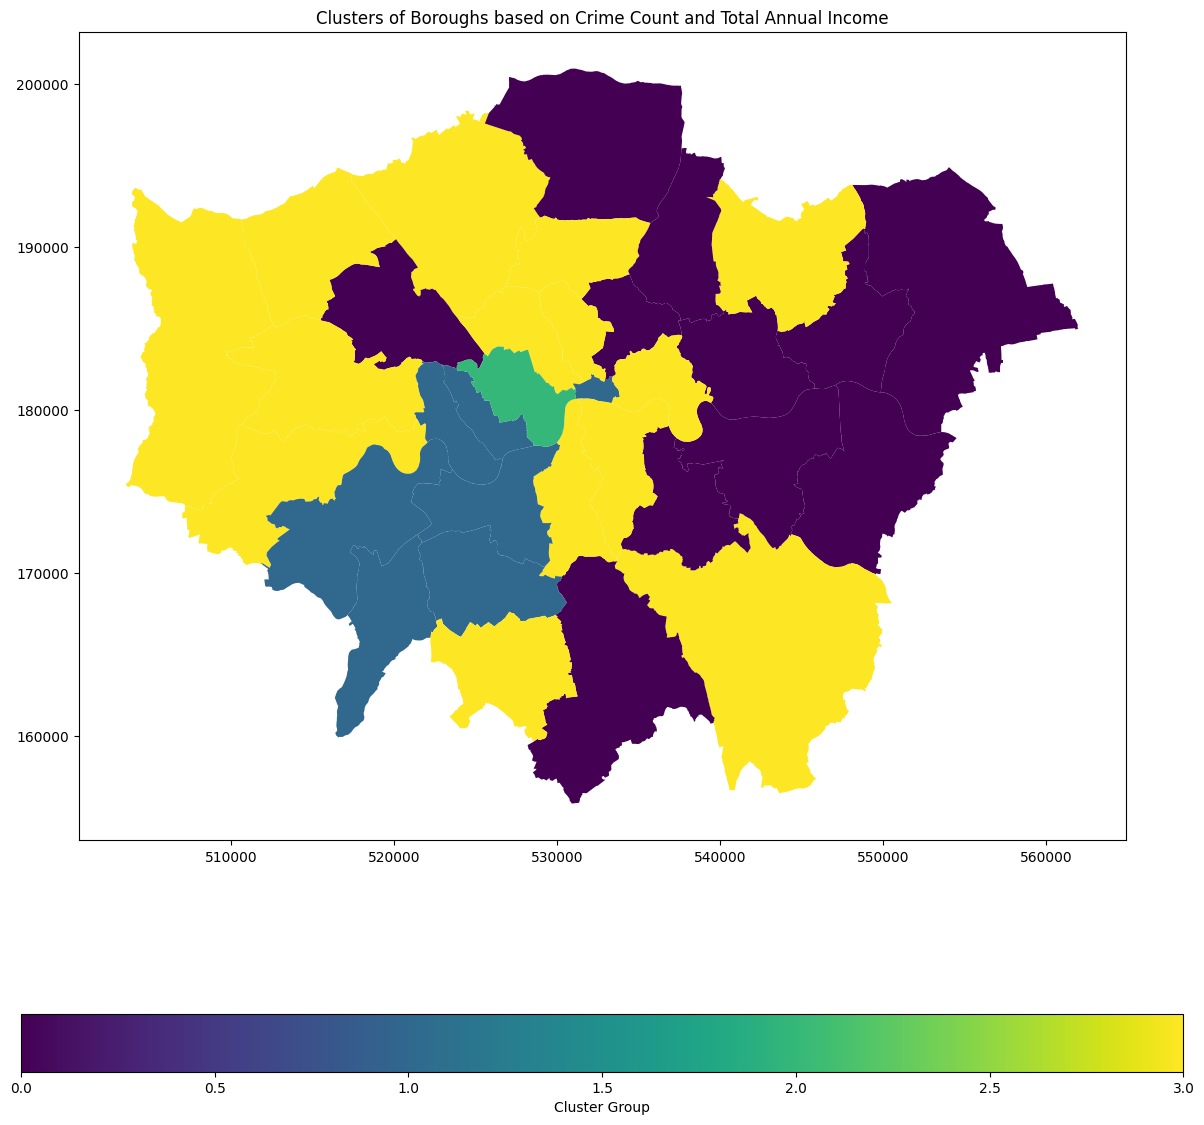

In [30]:
features_df = crime_religion_df[['CrimeCount', 'Total annual income (£)']]
features_df = features_df.fillna(features_df.mean())
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)


# Elbow Method
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)
crime_religion_df['Cluster'] = cluster_labels


# List of boroughs by cluster
for cluster in sorted(crime_religion_df['Cluster'].unique()):
    print(f"Cluster {cluster}:")
    boroughs_in_cluster = crime_religion_df[crime_religion_df['Cluster'] == cluster]['District'].unique()
    print(boroughs_in_cluster)
    print("\n")


boroughs_df = boroughs_df[['District', 'geometry']]
boroughs_with_clusters = boroughs_df.merge(crime_religion_df[['District', 'Cluster']].drop_duplicates(), on='District', how='left')
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
boroughs_with_clusters.plot(column='Cluster', ax=ax, legend=True, cmap='viridis',
                            legend_kwds={'label': "Cluster Group", 'orientation': "horizontal"})
plt.title('Clusters of Boroughs based on Crime Count and Total Annual Income')
plt.show()


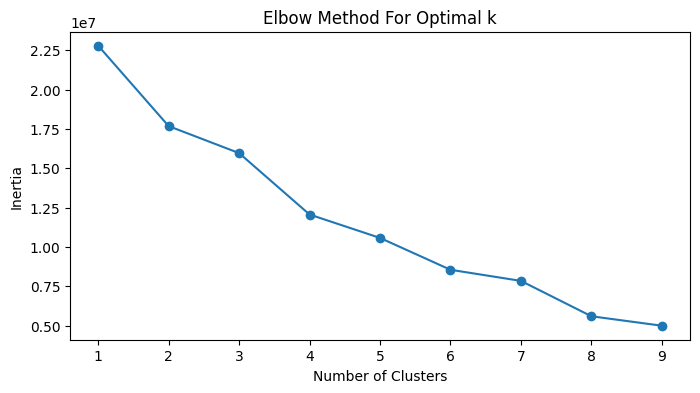

Cluster 0:
['Barking And Dagenham' 'Croydon' 'Enfield' 'Havering' 'Waltham Forest']


Cluster 1:
['Bexley' 'Greenwich' 'Bromley' 'Lewisham' 'Islington' 'City Of London'
 'Lambeth' 'Hammersmith And Fulham' 'Kensington And Chelsea'
 'Kingston Upon Thames' 'Southwark' 'Merton' 'Richmond Upon Thames'
 'Sutton' 'Wandsworth']


Cluster 2:
['Brent' 'Ealing' 'Hillingdon' 'Harrow' 'Hounslow' 'Newham' 'Redbridge']


Cluster 3:
['Barnet' 'Camden' 'Westminster' 'Hackney' 'Haringey' 'Tower Hamlets']




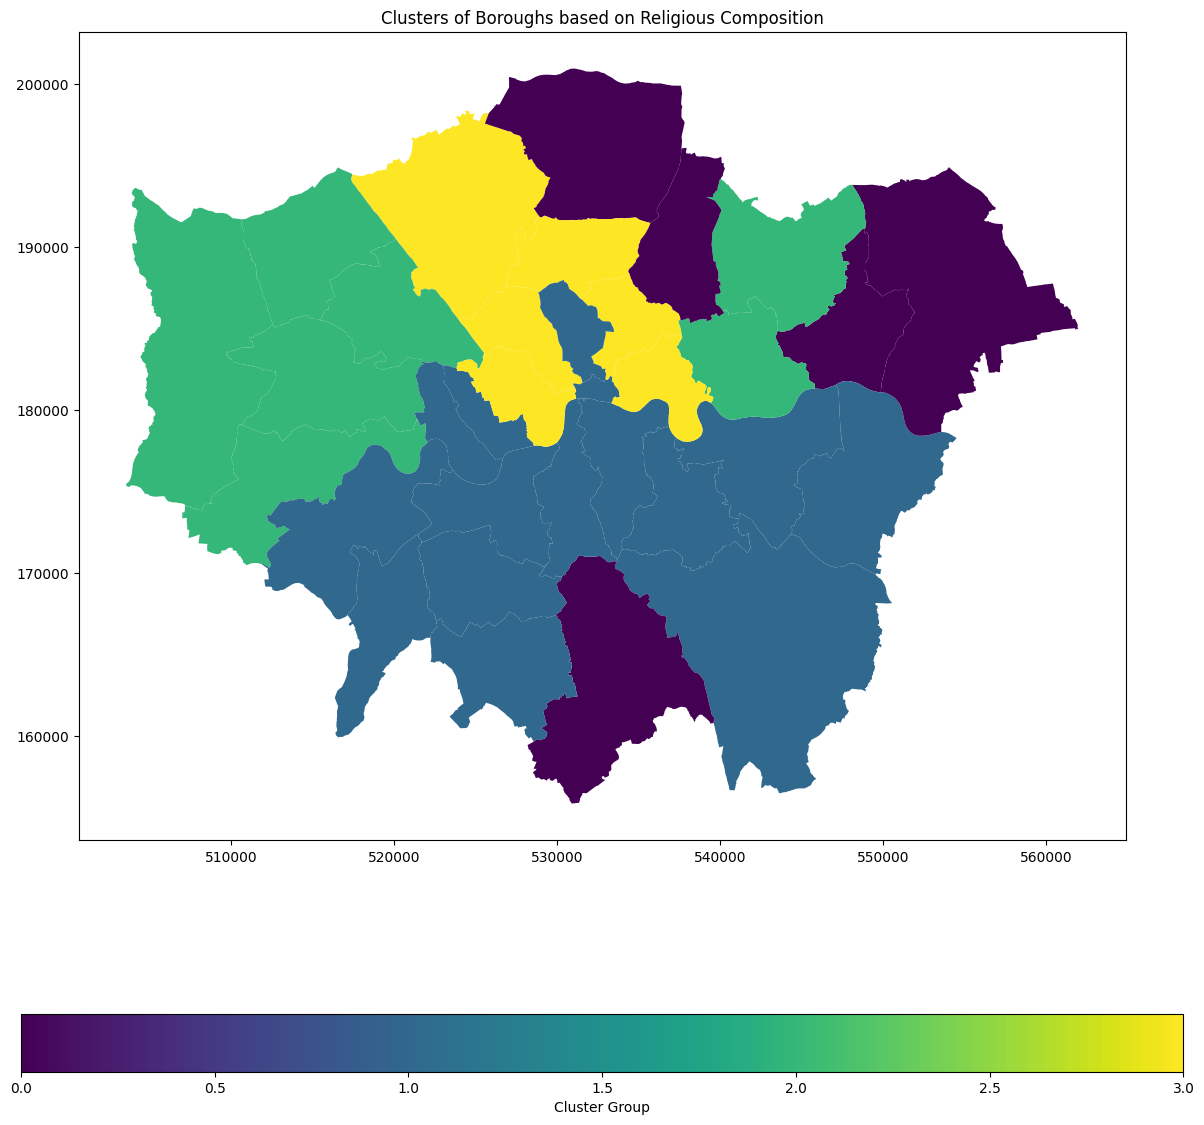

In [37]:
features_df = crime_religion_df[['No religion\n(percent)', 'Christian\n(percent)', 'Buddhist\n(percent)',
                                 'Hindu\n(percent)', 'Jewish\n(percent)', 'Muslim\n(percent)',
                                 'Sikh\n(percent)', 'Other religion\n(percent)', 'CrimeCount']]
features_df = features_df.fillna(features_df.mean())



scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)


inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)
crime_religion_df['Cluster'] = cluster_labels


for cluster in sorted(crime_religion_df['Cluster']. unique()):
    print(f"Cluster {cluster}:")
    boroughs_in_cluster = crime_religion_df[crime_religion_df['Cluster'] == cluster]['District'].unique()
    print(boroughs_in_cluster)
    print("\n")

boroughs_with_clusters = boroughs_df.merge(crime_religion_df[['District', 'Cluster']].drop_duplicates(), on='District', how='left')

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
boroughs_with_clusters.plot(column='Cluster', ax=ax, legend=True, cmap='viridis',
                            legend_kwds={'label': "Cluster Group", 'orientation': "horizontal"})
plt.title('Clusters of Boroughs based on Religious Composition')
plt.show()

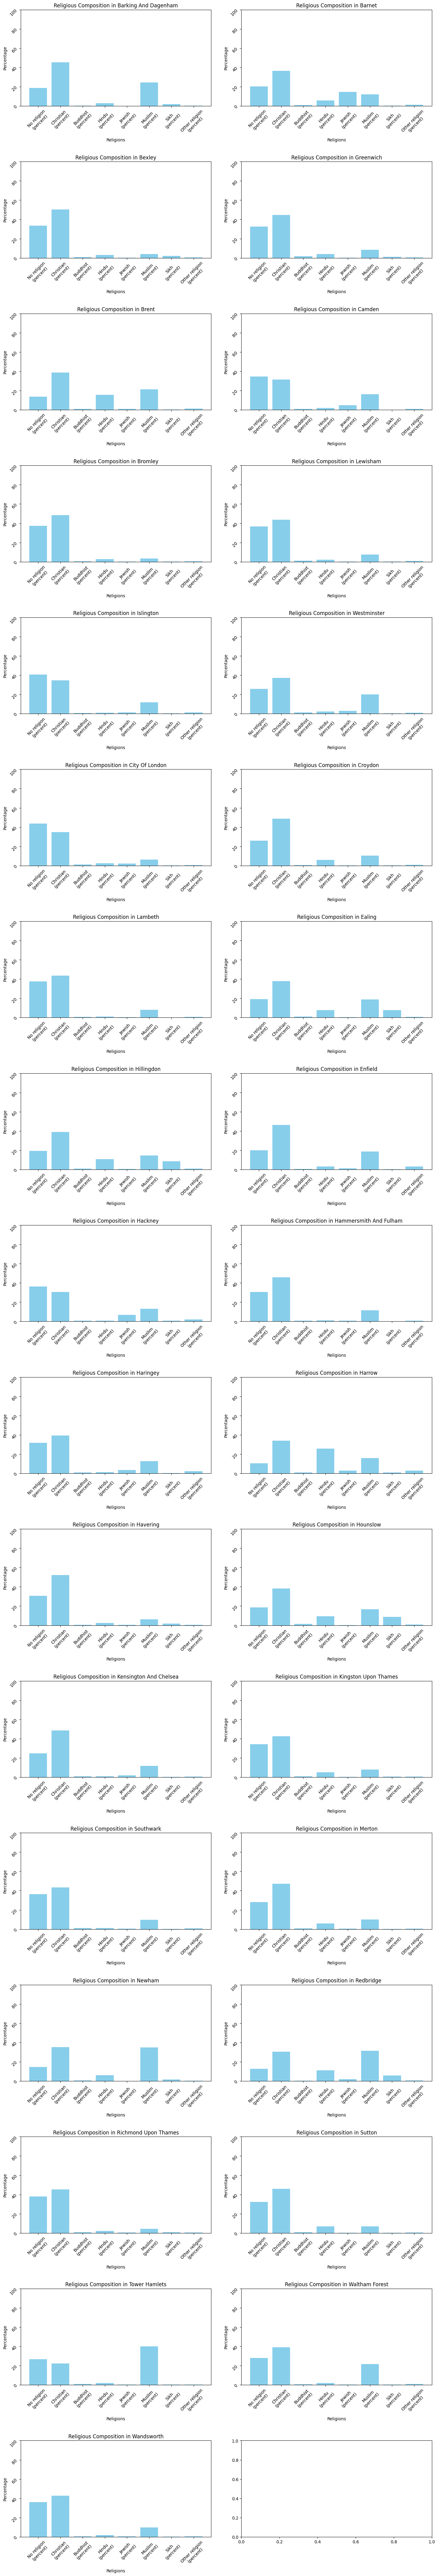

In [51]:
religion_columns = ['No religion\n(percent)', 'Christian\n(percent)', 'Buddhist\n(percent)',
                    'Hindu\n(percent)', 'Jewish\n(percent)', 'Muslim\n(percent)',
                    'Sikh\n(percent)', 'Other religion\n(percent)']

num_districts = len(crime_religion_df['District'].unique())
num_rows = -(-num_districts // 2)
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 5 * num_rows))
axs = axs.flatten()

for i, district in enumerate(crime_religion_df['District'].unique()):

    data = crime_religion_df[crime_religion_df['District'] == district].iloc[0]
    religion_percentages = [data[religion] for religion in religion_columns]
    
    axs[i].bar(religion_columns, religion_percentages, color='skyblue')
    axs[i].set_title(f'Religious Composition in {district}')
    axs[i].set_ylabel('Percentage')
    axs[i].set_xlabel('Religions')
    axs[i].tick_params(labelrotation=45)
    axs[i].set_ylim(0, 100)

if num_districts % 2 != 0:
    axs[-1].axis('off')  # Hide the last subplot if the total number of districts is odd

plt.tight_layout(pad=3.0)
plt.show()


In [46]:
age_dummies = pd.get_dummies(crime_religion_df['Age range'])
crime_religion_df = pd.concat([crime_religion_df, age_dummies], axis=1)



features = crime_religion_df[['10-17', '18-24', '25-34', 'over 34', 'CrimeCount']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow graph to find the optimal k
plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

optimal_k = 4  # Example placeholder
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)
crime_religion_df['Age_Cluster'] = cluster_labels



# Count of each age range category per cluster
for i in range(optimal_k):
    print(f"Cluster {i}:")
    cluster_data = crime_religion_df[crime_religion_df['Age_Cluster'] == i]
    summary = cluster_data[['10-17', '18-24', '25-34', 'over 34']].mean()
    print(summary)
    print("\n")



fig, axs = plt.subplots(optimal_k, 1, figsize=(10, 5 * optimal_k))

for i in range(optimal_k):
    axs[i].bar(['10-17', '18-24', '25-34', 'over 34'], crime_religion_df[crime_religion_df['Age_Cluster'] == i][['10-17', '18-24', '25-34', 'over 34']].mean())
    axs[i].set_title(f'Cluster {i} Age Distribution')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlabel('Age Ranges')

plt.tight_layout()
plt.show()


KeyError: 'Age'